# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pymongo import MongoClient

In [2]:
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"

client = MongoClient(mongo_uri)
db = client["ca2"]
collection = db["vaccin_tweets_2_202004"]
collection_sentiment = db["vaccin_tweets_2_202004_sentiment"]

# Convert MongoDB collection to pandas DataFrame
data = pd.DataFrame(list(collection.find()))
data_sentiment = pd.DataFrame(list(collection_sentiment.find()))


In [3]:
data.head()

,_id,coordinates,text,timestamp,timestamp_ms
0,1255385449109037058,None,COVID-ALERT: Pfizer coronavirus vaccine could ...,2020-04-29 06:36:29.658,1588142189658
1,1255387944732557315,None,"Dr David Eedes, clinical oncology advisor of I...",2020-04-29 06:46:24.661,1588142784661
2,1255388825532203009,None,@elonmusk @RationalEtienne 👏👏👏 maintain medica...,2020-04-29 06:49:54.660,1588142994660
3,1255390373234556929,None,THE CORONAVIRUS VACCINE: Should You Get The Co...,2020-04-29 06:56:03.661,1588143363661
4,1255391195313954820,None,RT @KTHopkins: A mandatory #COVID19 vaccine. \...,2020-04-29 06:59:19.660,1588143559660


In [4]:
data_sentiment.head()

,_id,sentiment,s_probability
0,1255385449109037058,neutral,0.812073
1,1255387944732557315,neutral,0.909928
2,1255388825532203009,neutral,0.451752
3,1255390373234556929,neutral,0.948563
4,1255391195313954820,neutral,0.841724


In [5]:
# Inner join
data = pd.merge(data, data_sentiment, on='_id', how='inner')

In [6]:
# Add Date column and create index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date

# Encode sentiments
data["sentiment_encoded"] = data["sentiment"].apply(lambda x: 2 if x == "positive" else -1 if x == "negative" else 1)
data["sentiment_score"] = data.apply(lambda row: row["sentiment_encoded"] * row["s_probability"], axis=1)
data['is_retweet'] = data['text'].apply(lambda x: 1 if 'RT' in x else 0)

# Calculate avg_sentiment_score
df_grouped = data.groupby('date').agg(avg_sentiment_score=('s_probability', 'mean'))
df_grouped['retweet_rate'] = data.groupby('date')['is_retweet'].mean()

<AxesSubplot:ylabel='Frequency'>

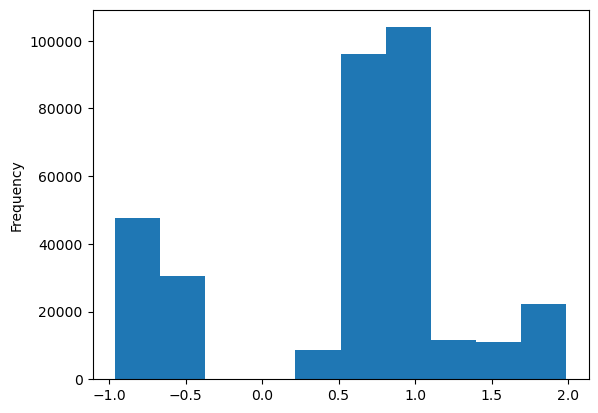

In [7]:
data["sentiment_score"].plot(kind='hist')

In [8]:
df_grouped.head()

,avg_sentiment_score,retweet_rate
date,,
2020-01-01,0.744125,0.333333
2020-01-02,0.751631,0.666667
2020-01-03,0.653364,0.454545
2020-01-04,0.759049,0.551724
2020-01-05,0.748756,0.661017


# Check stationationary

In [9]:
# Check for stationarity with Dickey-Fuller test
result = adfuller(df_grouped['avg_sentiment_score'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



ADF Statistic: -5.754011
p-value: 0.000001


> Data is stationary 

In [10]:
startdate = pd.to_datetime("2020-04-01").date()
split_date = pd.to_datetime("2020-12-31").date()
enddate = pd.to_datetime("2021-04-01").date()

In [11]:
# Prepare train and test datasets
train = df_grouped.loc[startdate:split_date]['avg_sentiment_score']
test = df_grouped.loc[split_date:enddate]['avg_sentiment_score']

In [12]:
train.count(), test.count()

(271, 73)

# Autocorrelation

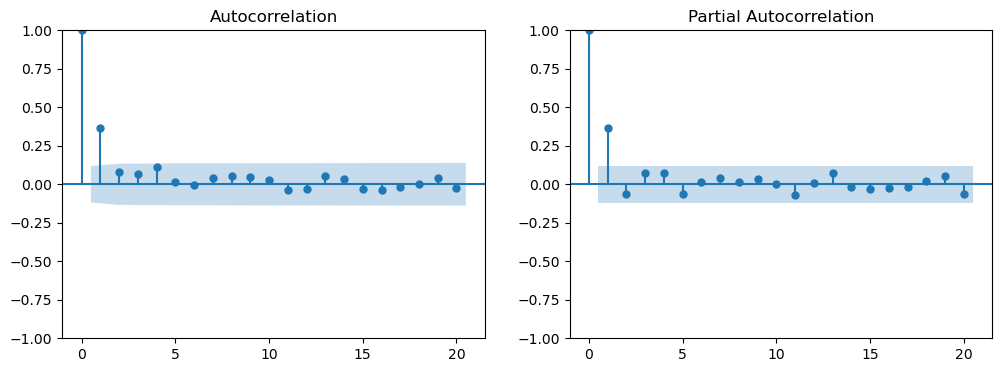

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train.values, lags=20, ax=ax1)
plot_pacf(train.values, lags=20, ax=ax2)
plt.show()

In [14]:
def get_errors(test_y, predictions):
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    mae = mean_absolute_error(test_y, predictions)
    smape = 200 * np.mean(np.abs(test_y - predictions) / (np.abs(test_y) + np.abs(predictions)))
    mase = mae / np.mean(np.abs(test_y[1:] - test_y[:-1]))
    r_squared = r2_score(test_y, predictions)
      
    return (rmse, mae, smape, mase, r_squared)

# SARIMA

In [15]:
p = 1
d = 0
q = 1
s = 28  # Seasonal period 7 days
P = 1
D = 1
Q = 1

model = SARIMAX(train.values, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

C:\Users\rmsry\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
predictions = results.get_forecast(steps=len(test.values))

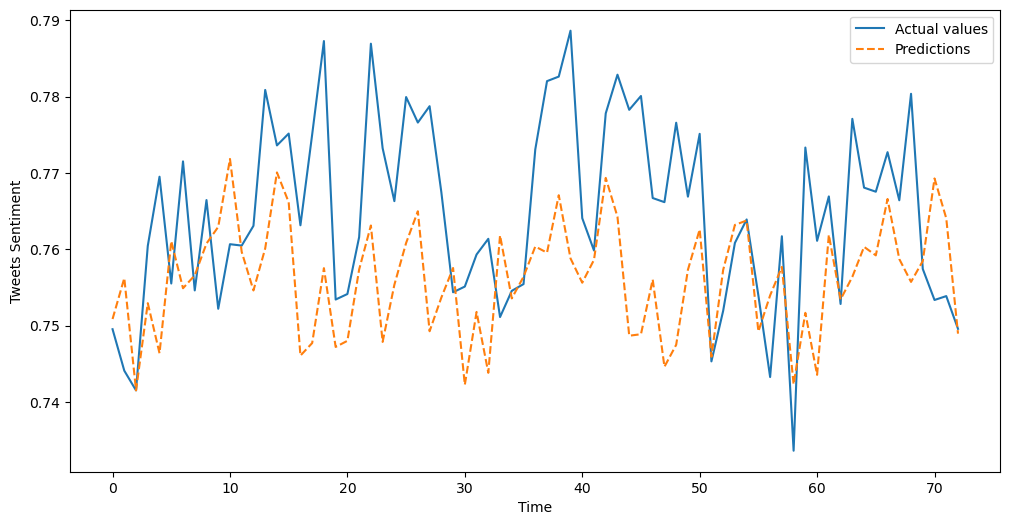

In [17]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test.values, label='Actual values')
plt.plot(predictions.predicted_mean, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Tweets Sentiment')
plt.legend()
plt.show()

In [19]:
#get_errors(np.array(test.values), predictions.predicted_mean)

## Save SARIMA model

> Best model: Save for process later

p = 1
d = 0
q = 1
s = 28  # Seasonal period 7 days
P = 1
D = 1
Q = 1

In [ ]:
sr_model = SARIMAXResults(model=model,params=)

# Autoarima - Hyper parameter tunning

In [ ]:
#%pip install pmdarima

In [ ]:
import pmdarima as pm

In [ ]:
auto_model = pm.auto_arima(train.values,
                      seasonal=True,
                      m=28,  # Seasonal frequency
                      start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal parameters
                      start_P=0, start_Q=0, max_P=3, max_Q=3,  # Seasonal parameters
                      d=0, D=3,  # Orders of differencing
                      trace=False,  # Print search information
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Stepwise search for efficiency

In [ ]:
model = SARIMAX(train.values, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions = results.get_forecast(steps=len(test.values))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test.values, mean_predictions))
print(f"RMSE: {rmse}")

In [ ]:
get_errors(np.array(test.values), predictions.predicted_mean)

In [ ]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test.values, label='Actual values')
plt.plot(predictions.predicted_mean, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Tweets Sentiment')
plt.legend()
plt.show()